In [1]:
# reset environment for reproducibility
%reset -f

In [1]:
import numpy as np
import os

import math
import time
import glob
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from PIL import Image

import tensorflow as tf
from tensorflow.keras import applications, backend, callbacks, layers
from tensorflow.keras import models, metrics, optimizers, preprocessing
from tensorflow.keras import regularizers, utils

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

In [2]:
# Seed randomness for reproducibility
SEED = 42
tf.random.set_seed(SEED)
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(SEED)))

# Suppress warnings
warnings.filterwarnings("ignore")

# Hyperparameters
EPOCHS = 2
PATIENCE = 4
BATCH_SIZE = 100
VALIDATION_FRAC = 0.30
INIT_LEARN_RATE = 0.1
FREEZE_LAYERS_FRAC = 0.94

# Inputs 
COLOR_MODE = 'grayscale'
INTERPOLATION = 'hamming'

TRAIN_DOWNSAMPLE_FRAC = 1.00

SCALE_DIM = 2 # Tested 1-7
XCEPT_DIM = 299
IMAGE_SIZE = (SCALE_DIM * XCEPT_DIM,
              SCALE_DIM * XCEPT_DIM)
IMAGE_SHAPE = IMAGE_SIZE + (1,)

# Model weights persistence
WEIGHTS_FILE = 'weights_{}_{}_{}_{}.h5'.format(
    IMAGE_SIZE[0], IMAGE_SIZE[1],
    int(FREEZE_LAYERS_FRAC * 100),
    int(TRAIN_DOWNSAMPLE_FRAC * 100))

# Classes
CLASS_H = 'Healthy'
CLASS_VPNA = 'Viral PNA'
CLASS_BPNA = 'Bacterial PNA'

# Stages
STAGE_TRAIN = 'train'
STAGE_VAL = 'val'
STAGE_TEST = 'test'

# Pathing
DATA_PATH = '../dataset'

# Logging
VERBOSE = 0

In [3]:
def gather_files_into_dataframe(path):
  
  frames = []

  for stage in (STAGE_TRAIN, STAGE_VAL, STAGE_TEST):
    
    for target in ('PNEUMONIA', 'NORMAL'):

      # Gather and sort file names
      filenames = pd.Series(glob.glob(os.path.join(
          path, stage, target, '*.jpeg')))
      filenames.sort_values(inplace=True)

      # Gather image dimensions
      widths, heights = zip(*[Image.open(filename).size
                              for filename in filenames])
      
      frames.append(pd.DataFrame({'filename': filenames,
                                  'width': widths,
                                  'height': heights,
                                  'stage': stage,
                                  'class': target}))

  return pd.concat(frames, ignore_index=True)

In [4]:
df = gather_files_into_dataframe(DATA_PATH)

In [5]:
df.sample(n=10, random_state=rs)

,filename,width,height,stage,class
2781,../dataset/train/PNEUMONIA/person516_bacteria_...,667,322,train,PNEUMONIA
1919,../dataset/train/PNEUMONIA/person305_bacteria_...,1008,624,train,PNEUMONIA
195,../dataset/train/PNEUMONIA/person110_virus_205...,1192,864,train,PNEUMONIA
5838,../dataset/test/NORMAL/NORMAL2-IM-0359-0001.jpeg,1450,1149,test,NORMAL
3744,../dataset/train/PNEUMONIA/person933_bacteria_...,1152,816,train,PNEUMONIA
5302,../dataset/test/PNEUMONIA/person122_bacteria_5...,864,496,test,PNEUMONIA
3011,../dataset/train/PNEUMONIA/person577_bacteria_...,1508,929,train,PNEUMONIA
5194,../dataset/train/NORMAL/NORMAL2-IM-1347-0001.jpeg,1932,1743,train,NORMAL
1066,../dataset/train/PNEUMONIA/person1492_virus_25...,1136,744,train,PNEUMONIA
2210,../dataset/train/PNEUMONIA/person371_bacteria_...,920,640,train,PNEUMONIA


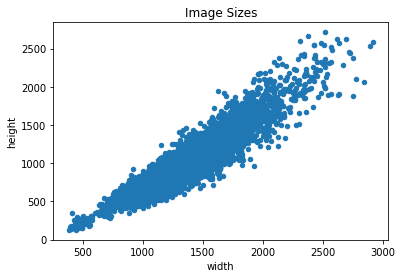

In [6]:
df.plot(x='width', y='height', kind='scatter',
        title='Image Sizes');

In [7]:
df.loc[:, ['width', 'height']].mean()

width     1327.880806
height     970.689037
dtype: float64

In [8]:
df.loc[:, ['width', 'height']].median()

width     1281.0
height     888.0
dtype: float64

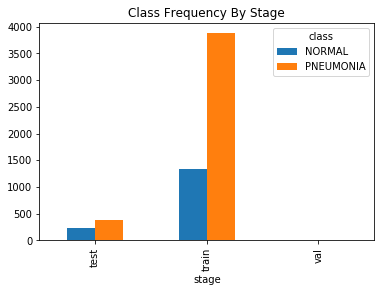

In [9]:
df.groupby(['stage', 'class']).size().unstack().plot(
    kind='bar', title='Class Frequency By Stage');

In [10]:
df.loc[df['class'] == 'NORMAL', 'class'] = CLASS_H

df.loc[(df['class'] == 'PNEUMONIA') 
  & (df['filename'].str.contains('_virus_')), 'class'] = CLASS_VPNA
  
df.loc[(df['class'] == 'PNEUMONIA') 
  & (df['filename'].str.contains('_bacteria_')), 'class'] = CLASS_BPNA

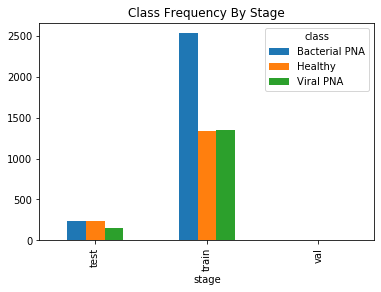

In [11]:
df.groupby(['stage', 'class']).size().unstack().plot(
    kind='bar', title='Class Frequency By Stage');

In [12]:
df.loc[df['stage'] == STAGE_VAL, 'stage'] = STAGE_TRAIN

In [13]:
def get_samp_ndx(df, stage, target, frac, random_state):
  return df[(df['stage'] == stage) 
    & (df['class'] == target)].sample(frac=frac, 
                                      random_state=rs).index

In [14]:
df.loc[get_samp_ndx(df, STAGE_TRAIN, CLASS_H, VALIDATION_FRAC, rs), 
       'stage'] = STAGE_VAL

df.loc[get_samp_ndx(df, STAGE_TRAIN, CLASS_VPNA, VALIDATION_FRAC, rs), 
       'stage'] = STAGE_VAL

df.loc[get_samp_ndx(df, STAGE_TRAIN, CLASS_BPNA, VALIDATION_FRAC, rs), 
       'stage'] = STAGE_VAL

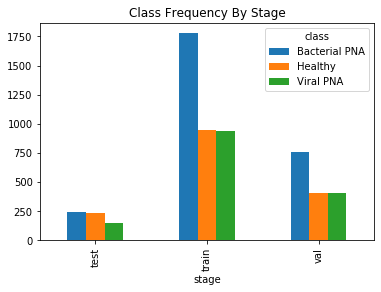

In [15]:
df.groupby(['stage', 'class']).size().unstack().plot(
    kind='bar', title='Class Frequency By Stage');

In [16]:
def plot_image_grid(files, title, 
                    color_mode=COLOR_MODE,
                    interpolation=INTERPOLATION):

    square = math.ceil(math.sqrt(len(files)))

    fig, axes = plt.subplots(nrows=square,
                           ncols=square, 
                           figsize=(10, 10))

    fig.suptitle(title, fontsize='xx-large')
    axes = axes.flatten()

    for (title, filename), ax in zip(files, axes):
        ax.set_title(f'{title}', fontsize='x-large')
        ax.imshow(preprocessing.image.load_img(filename, 
                                               color_mode=color_mode),
                  interpolation=interpolation)

    for ax in axes:
        ax.axis('off')

    plt.tight_layout(pad=4)
    plt.show()

In [17]:
def get_sample_files(df, stage, target, n, random_state):
  return list(df.loc[(df['stage'] == stage) & (df['class'] == target),
                     ['class', 'filename']].sample(n=n, 
                                                   random_state=random_state)
                     .itertuples(name=None, index=False))

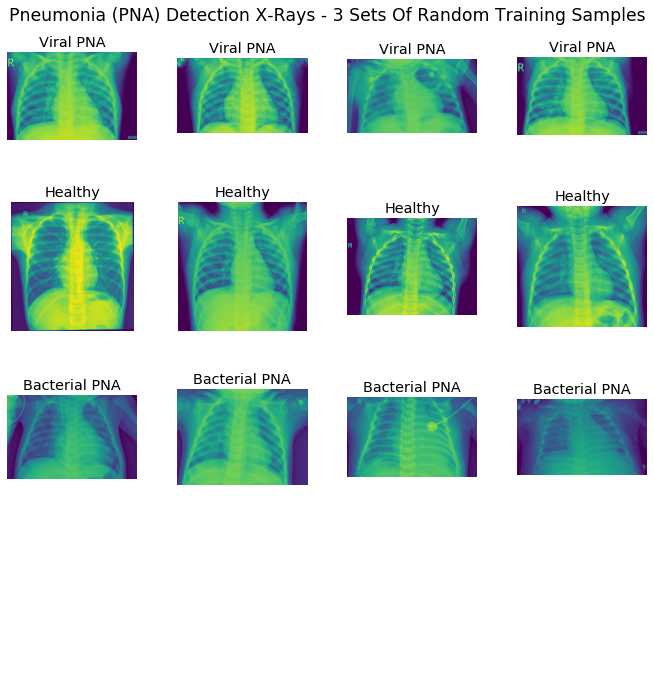

In [18]:
plot_image_grid(get_sample_files(df, STAGE_TRAIN, CLASS_VPNA, 4, rs) + 
                get_sample_files(df, STAGE_TRAIN, CLASS_H, 4, rs) + 
                get_sample_files(df, STAGE_TRAIN, CLASS_BPNA, 4, rs),
                'Pneumonia (PNA) Detection X-Rays'
                ' - 3 Sets Of Random Training Samples')

In [19]:
def get_dataframe_sample(df, stage, frac=1.0, random_state=None):
  return df[df['stage'] == stage].sample(frac=frac, 
                                         random_state=random_state)

In [20]:
preproc_gen = preprocessing.image.ImageDataGenerator(
    preprocessing_function=applications.xception.preprocess_input)

flow_params = dict(
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    target_size=IMAGE_SIZE,
    color_mode=COLOR_MODE,
    interpolation=INTERPOLATION,
    validate_filenames=False,
    seed=SEED)

# Construct iterators using DataFrame

train_iterator = preproc_gen.flow_from_dataframe(
    get_dataframe_sample(df, STAGE_TRAIN, TRAIN_DOWNSAMPLE_FRAC, rs),
    **flow_params)

validation_iterator = preproc_gen.flow_from_dataframe(
    get_dataframe_sample(df, STAGE_VAL, TRAIN_DOWNSAMPLE_FRAC, rs),
    **flow_params)

test_iterator = preproc_gen.flow_from_dataframe(
    df[df['stage'] == STAGE_TEST], shuffle=False,
    **flow_params)

Found 3662 non-validated image filenames belonging to 3 classes.
Found 1570 non-validated image filenames belonging to 3 classes.
Found 624 non-validated image filenames belonging to 3 classes.


In [21]:
# Show pie chart if using partial training data
if TRAIN_DOWNSAMPLE_FRAC < 1.0:
  plt.pie([TRAIN_DOWNSAMPLE_FRAC, 1-TRAIN_DOWNSAMPLE_FRAC],
          labels=[f'Down-sampled Data Employed {TRAIN_DOWNSAMPLE_FRAC:.0%}', 
                   'Down-sampled Data Available'])

In [22]:
def construct_model():

  # Input layer to functional API model
  x = input = layers.Input(shape=IMAGE_SHAPE)

  # Conv2D for grayscale to (x, y, 3)
  x = layers.Conv2D(3, SCALE_DIM,
                    padding='same',
                    kernel_regularizer='L2',
                    activation='relu')(x)

  # Pooling reduction layer, if needed
  if SCALE_DIM > 1:
    x = layers.MaxPooling2D(SCALE_DIM)(x)

  # Xception base model
  Xception = applications.Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(XCEPT_DIM, XCEPT_DIM, 3))
  
  # Freeze the first % layers
  freeze = round(FREEZE_LAYERS_FRAC * len(Xception.layers))
  for i, layer in enumerate(Xception.layers, start=1):
    layer.trainable = i > freeze

  # Debug
  if VERBOSE:
    trainable_flags = [layer.trainable for layer in Xception.layers]
    print(trainable_flags)
    print(sum(trainable_flags)/len(Xception.layers))

  x = Xception(x)

  # Pool results from Xception
  x = layers.GlobalMaxPool2D()(x)

  # Inference layer
  x = output = layers.Dense(3, activation='softmax')(x)

  # Connect functional API model
  model = models.Model(input, output)

  return model

In [26]:
weights_loaded = False

model = construct_model()

if os.path.exists(WEIGHTS_FILE):
  weights_loaded = True  
  model.load_weights(WEIGHTS_FILE)
  print(f'Model initialized with weights: {WEIGHTS_FILE}')
else:
  print(f'Model partially initialized with imagenet.')

utils.plot_model(model, show_shapes=True, show_dtype=True)

Model partially initialized with imagenet.
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [27]:
## Jupyter is being annoying and not connecting to my terminal installs

# import sys
# !{sys.executable} -m pip install graphviz 

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 598, 598, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 598, 598, 3)       15        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 20,867,642
Trainable params: 4,757,010
Non-trainable params: 16,110,632
_______________________________________

In [29]:
def compile_model(model, metrics):

  optimizer = optimizers.RMSprop(learning_rate=INIT_LEARN_RATE)

  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=metrics) 

In [30]:
def fit_model(model, train_iterator, validation_iterator):
  
  # Learning rate scheduling
  def lr_scheduler(epoch, lr):
    DROP = 0.94
    EPOCHS_DROP = 2
    rate = INIT_LEARN_RATE * math.pow(DROP, math.floor((1+epoch)/EPOCHS_DROP))
    return rate

  schedule_lr = callbacks.LearningRateScheduler(lr_scheduler)

  # Early stopping
  stop_early = callbacks.EarlyStopping(patience=PATIENCE,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)
  
  # Address class imbalance with loss weightings
  weights = class_weight.compute_class_weight(
      'balanced',
      list(train_iterator.class_indices.values()),
      train_iterator.classes)
  
  weight_dict = {i: weights[i] 
                 for i in train_iterator.class_indices.values()}

  if VERBOSE:
    print('Loss weights:', weight_dict)
  
  return model.fit(train_iterator,
                   validation_data=validation_iterator,
                   class_weight=weight_dict,
                   callbacks=[schedule_lr, stop_early],
                   epochs=EPOCHS,                   
                   verbose=VERBOSE)

In [31]:
compile_model(model, ['accuracy', metrics.TopKCategoricalAccuracy(2)])

if not weights_loaded:
  backend.clear_session()
  history = fit_model(model, 
                      train_iterator, 
                      validation_iterator)
  model.save_weights(WEIGHTS_FILE)
  print(f'Model weights saved: {WEIGHTS_FILE}')  
else:
  print('Nothing to do.')

KeyboardInterrupt: 

In [ ]:
loss, acc, top2acc = model.evaluate(test_iterator, verbose=VERBOSE)
print(f'Test Loss: {loss:.4}')
print(f'Test ACC: {acc:.2%}')
print(f'Test Top 2 ACC: {top2acc:.2%}')

In [202]:
def plot_evaluation(loss, acc, history, plot_title):

  # History DataFrame
  hist_df = pd.DataFrame(history.history)
  hist_df.insert(0, 'Epoch',
                 np.arange(1, len(hist_df)+1))
  hist_df.rename(inplace=True,
                 columns={
                     'loss': 'Training Loss',
                     'val_loss': 'Validation Loss',
                     'accuracy': 'Training ACC', 
                     'val_accuracy': 'Validation ACC',
                     'top_k_categorical_accuracy': 'Top 2 Training ACC',
                     'val_top_k_categorical_accuracy': 'Top 2 Validation ACC',
                     'lr': 'Learning Rate'
                     }
                 )

  # Plots
  fig, axes = plt.subplots(nrows=1, ncols=2,
                           figsize=(10, 5))
  fig.suptitle(plot_title)
  hist_df.plot(ax=axes[0],
              title='Validation & Training Loss',
              x='Epoch', y=['Validation Loss', 'Training Loss'])
  hist_df.plot(ax=axes[1],
              title='Validation & Training Accuracy',
              x='Epoch', y=['Validation ACC', 'Training ACC',
                            'Top 2 Validation ACC'])

  # Plot evaluation
  plt.figtext(0.5, -0.1, 
              f'Test Loss={loss:.4} -- Test Accuracy={acc:.2%}',
              size='x-large', horizontalalignment='center')

  plt.show()

  return hist_df

In [203]:
if not weights_loaded:
  hist_df = plot_evaluation(loss, acc, history,
                            'X-Ray PNA Classification'
                            ' With Xception Architecture')

NameError: name 'loss' is not defined

In [204]:
hist_df[:-PATIENCE] if not weights_loaded else None

NameError: name 'hist_df' is not defined

In [205]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      # print("Normalized confusion matrix")
  # else:
      # print('Confusion matrix, without normalization')

  # print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, f'{cm[i, j]:.3}' if normalize else cm[i, j],
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

In [206]:
preds = model.predict(test_iterator)

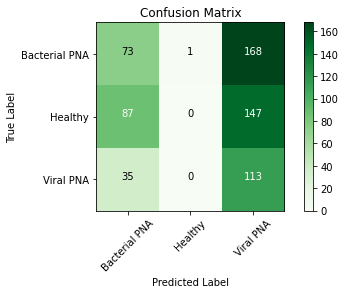

In [207]:
cm = confusion_matrix(test_iterator.classes, preds.argmax(axis=1))
plot_confusion_matrix(cm, test_iterator.class_indices.keys(),
                      cmap=plt.cm.Greens,
                      normalize=False)

In [208]:
def get_error_files(preds, test_iterator):
  lookup = {v: k for k, v in test_iterator.class_indices.items()}
  pred_classes = preds.argmax(axis=1)
  errors, = np.where(pred_classes != test_iterator.classes)
  return [(f'{lookup[test_iterator.classes[i]]}'
            '\n'
           f'Predicted {lookup[pred_classes[i]]}'
           f' {preds[i][pred_classes[i]]:.2%}',
           test_iterator.filenames[i]) for i in errors]

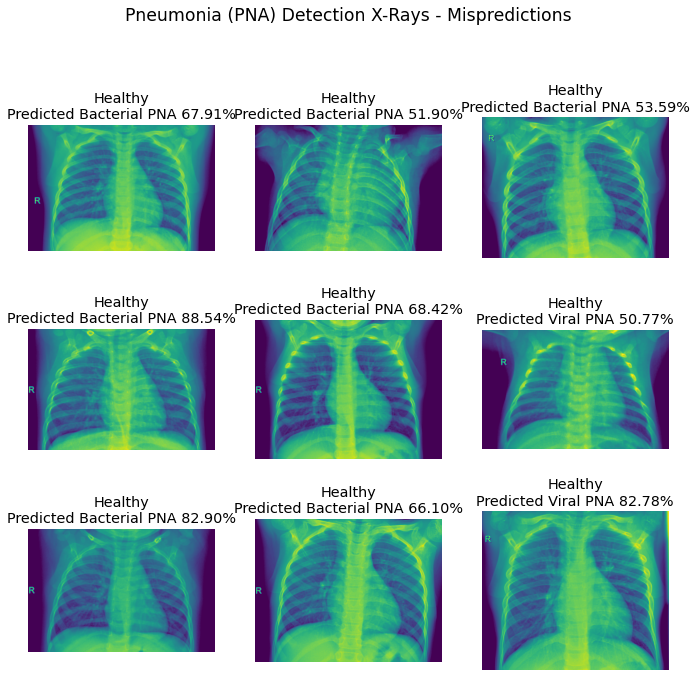

In [209]:
plot_image_grid(get_error_files(preds, test_iterator)[-9:],
                'Pneumonia (PNA) Detection X-Rays - Mispredictions')

In [210]:
def plot_test_image_sizes(test_set, preds, test_iterator):
  
  fig, axes = plt.subplots(nrows=1, ncols=2,
                           figsize=(10, 5))
  
  fig.suptitle('Test Image Sizes')

  test_set[preds.argmax(axis=1) != test_iterator.classes].plot(
      ax=axes[0],
      x='width', y='height', kind='scatter',
      title='Mispredicted')
  
  test_set[preds.argmax(axis=1) == test_iterator.classes].plot(
      ax=axes[1],
      x='width', y='height', kind='scatter',
      title='Accurately Predicted')
  
  plt.show()

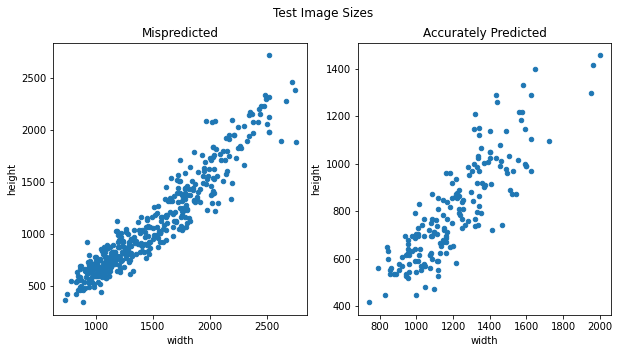

In [211]:
plot_test_image_sizes(df[df['stage'] == STAGE_TEST], preds, test_iterator)

In [212]:
## Jupyter is being annoying and not connecting to my terminal installs

#import sys

#!{sys.executable} -m pip install tensorflow